# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record



In [260]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

%matplotlib inline

In [261]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

To check the size of our datasets:

In [262]:
print('portfolio: ',portfolio.shape)
print('profile: ',profile.shape)
print('transcript: ',transcript.shape)

portfolio:  (10, 6)
profile:  (17000, 5)
transcript:  (306534, 4)


In [263]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [264]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


There are many entries with NaN and invalid values like the age of 118. It is probably safe to delete those rows. 

In [265]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


# Data Cleaning
The data will need to be cleaned and altered to be able to properly visualize and analyze its content.


In [266]:
def create_mapping_dict(pd,column):
    """ 
    Creates a dictionary that maps all unique strings to integers
  
    Parameters: 
    pd: pandas dataframe 
    column (string): the name of column where mapping is needed
    
    Returns: 
    dict_map (dictionary): python dictionary where keys are strings and values are the mapped integers 
  
    """
    
    dict_map = dict([(y,x+1) for x,y in enumerate(sorted(set(pd[column])))])
    return dict_map

In [267]:
def map_string_to_int(pd,column,dict_map):
    """ 
    Maps each string in the original column to its respective integer.
  
    Parameters: 
    pd (pandas dataframe): original input dataframe 
    column (string): the name of column where mapping is needed
    dict_map (dictionary): python dictionary where keys are strings and values are the mapped integers
    
    Returns: 
    pd (pandas dataframe):  dataframe after the specified column was modified
  
    """
    list_map = []
    for x in pd[column]:
        if x in dict_map:
            list_map.append(dict_map[x])
        else:
            list_map.append(x)
            
    pd[column] = list_map
    return pd


### portfolio dataset 
In this dataset we can do the following:
1. Expand "channels" into binary columns of all different channels in the dataset (email, web, mobile, social)
2. Expand "offer_type" into binary columns for all different offer types.
3. Replace the long hash value of id with an integer.
4. Check for any null or duplicate values


In [268]:
# Generate dummy columns of categorical variables

# 1- channels dummies
#get items from list to prepare for get_dummies
channel_dummies = portfolio['channels'].apply(lambda x: str(x)[1:-1].replace('\'',''))
channel_dummies = channel_dummies.str.get_dummies(sep = ', ')


# 2- offer_type dummies
offer_dummies = pd.get_dummies(portfolio['offer_type'])


# Concatinate new columns to portofolio and remove old columns
portfolio = pd.concat([portfolio,offer_dummies,channel_dummies],axis=1).drop(['channels'],axis=1)


# 3- Replace hash with integer
offer_map = create_mapping_dict(portfolio,'id')
portfolio = map_string_to_int(portfolio, 'id',offer_map)

portfolio.head()

,reward,difficulty,duration,offer_type,id,bogo,discount,informational,email,mobile,social,web
0,10,10,7,bogo,8,1,0,0,1,1,1,0
1,10,10,5,bogo,5,1,0,0,1,1,1,1
2,0,0,4,informational,4,0,0,1,1,1,0,1
3,5,5,7,bogo,7,1,0,0,1,1,0,1
4,5,20,10,discount,1,0,1,0,1,0,0,1


In [269]:
#check for null values
portfolio.isnull().sum()

reward           0
difficulty       0
duration         0
offer_type       0
id               0
bogo             0
discount         0
informational    0
email            0
mobile           0
social           0
web              0
dtype: int64

In [270]:
#check for duplicates
print(portfolio[portfolio.duplicated()])

Empty DataFrame
Columns: [reward, difficulty, duration, offer_type, id, bogo, discount, informational, email, mobile, social, web]
Index: []


### profile dataset 
In this dataset we can do the following:
1. Replace the long hash value of id with an integer.
2. Remove Nan and invalid values (eg: Age = 118)
3. format 'became_member_of' column to Y-M-D
4. check for duplicate users

In [271]:
#1- Replace hash with integer
profile_map = create_mapping_dict(profile, 'id')
profile = map_string_to_int(profile, 'id',profile_map)

In [272]:
# 2- Remove Nan and invalid values (eg: Age = 118)
#check number of nan values
print(profile.isnull().sum())

#check the rows with Age > 110
print(profile[profile.age > 110].info())

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 16994
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            0 non-null      object 
 1   age               2175 non-null   int64  
 2   id                2175 non-null   int64  
 3   became_member_on  2175 non-null   int64  
 4   income            0 non-null      float64
dtypes: float64(1), int64(3), object(1)
memory usage: 102.0+ KB
None


It seems like the invalid ages are a dummy fill up for rows with null values.
Since the entire row (age, gender, income) is filled with null values, we can remove them as they are useless to our analysis.

In [273]:
#remove the 2175 rows
profile.dropna(inplace=True)

print('profile' ,profile.shape)

#3- format 'became_member_of' column to Y-M-D
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'],format='%Y%m%d')

profile.head()

profile (14825, 5)


,gender,age,id,became_member_on,income
1,F,55,399,2017-07-15,112000.0
3,F,75,7997,2017-05-09,100000.0
5,M,68,15044,2018-04-26,70000.0
8,M,65,3729,2018-02-09,53000.0
12,M,58,3060,2017-11-11,51000.0


In [274]:
print(profile[profile.duplicated()])

Empty DataFrame
Columns: [gender, age, id, became_member_on, income]
Index: []


### transcript dataset 
In this dataset we can do the following:
1. Expand "event" into binary columns of all different events in the dataset
2. Edit the 'value' column and expand it into (offer_id, amount, reward) columns
3. map the person and offer id to their respective integers.
4. check for duplicate and Nan events

In [275]:
# 1- Expand "event" into binary columns of all different events in the dataset
event_dummy = pd.get_dummies(transcript['event'])
# Concatinate new columns to transcript
transcript = pd.concat([transcript, event_dummy],axis = 1).drop(['event'],axis=1)


# 2-Edit the 'value' column and expand it into (offer_id, amount, reward) columns

# Create offer_id column to hold the offer id of the value column. If no offer_id, replace it with Nan.
transcript['offer_id'] = transcript.value.apply(lambda x: x['offer id'] if 'offer id' in x else\
                                                x['offer_id'] if 'offer_id' in x else np.nan)

#Create amount column to hold the transaction amount. If no amount, replace it with zero
transcript['amount'] = transcript.value.apply(lambda x: x['amount'] if 'amount' in x else 0)
                                                
# Generate reward column to hold the reward value. If no reward, replace it with zero.
transcript['reward_given'] = transcript.value.apply(lambda x: x['reward'] if 'reward' in x else 0)

# Remove value column
transcript.drop(['value'],axis=1,inplace=True)

# 3- map the person and offer id to their respective integers.
transcript = map_string_to_int(transcript,'offer_id',offer_map)
transcript = map_string_to_int(transcript,'person',profile_map)

In [276]:
transcript.head()

,person,time,offer completed,offer received,offer viewed,transaction,offer_id,amount,reward_given
0,7997,0,0,1,0,0,7.0,0.0,0
1,10736,0,0,1,0,0,1.0,0.0,0
2,15044,0,0,1,0,0,3.0,0.0,0
3,9525,0,0,1,0,0,10.0,0.0,0
4,6940,0,0,1,0,0,5.0,0.0,0


In [277]:
#print(transcript[transcript.duplicated()])
# Remove duplicated rows
transcript.drop_duplicates(inplace=True)

transcript.shape

(306137, 9)

# Data Exploration
After data was cleaned, we will explore differnt features and answer some questions with the help of charts.

In [278]:
sns.set()
base_color = sns.color_palette()

### Q1. What are the users age and gender distribution in the dataset?

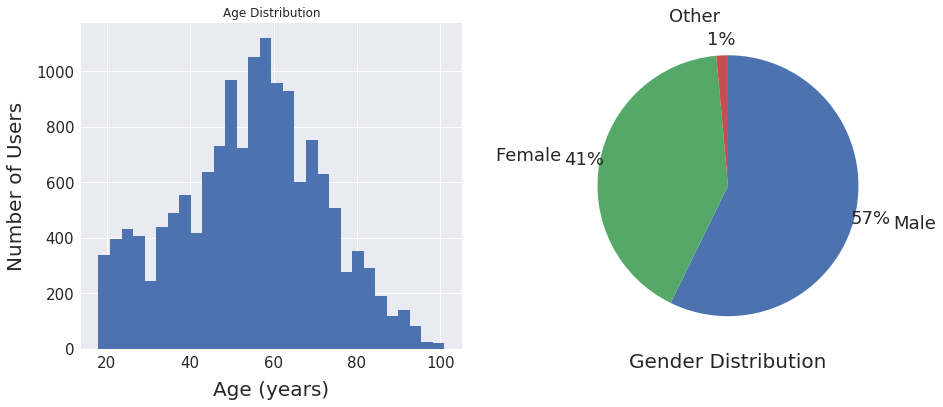

In [279]:
#age histogram
age_dist = profile['age']
plt.figure(figsize = [15,6])
plt.subplot(1,2,1)
plt.hist(age_dist, bins = 30);
plt.title('Age Distribution')
plt.xlabel('Age (years)',fontsize=20,labelpad=10)
plt.ylabel('Number of Users',fontsize=20,labelpad=10);
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);


plt.subplot(1,2,2)
gend_dist = profile['gender'].value_counts()
gend_dist.plot(kind='pie',startangle = 90,counterclock=False,autopct='%1.0f%%',\
               labels=['Male','Female','Other'],\
               textprops={'fontsize': 18},pctdistance=1.12,labeldistance=1.3)
plt.ylabel('')
plt.xlabel('Gender Distribution',fontsize=20);

### Q2. How is the data distributed between different events?

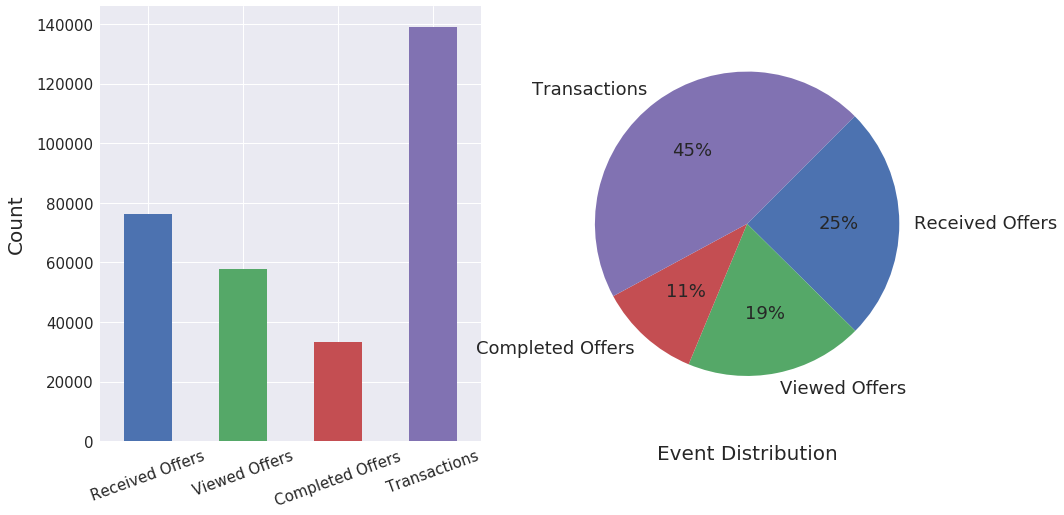

In [280]:
event_dist = transcript[['offer received','offer viewed','offer completed','transaction']].sum()

# Plotting
plt.figure(figsize = [15,8])

# Bar chart
plt.subplot(1,2,1)
event_dist.plot(kind='bar' , color = base_color)
plt.xticks([0,1,2,3],['Received Offers','Viewed Offers','Completed Offers','Transactions'],rotation = 20,\
          fontsize=15);
plt.ylabel('Count',fontsize=20,labelpad=10,rotation = 90)
plt.yticks(fontsize=15);

# Pie chart
plt.subplot(1,2,2)
event_dist.plot(kind='pie',startangle = 45,counterclock=False,autopct='%1.0f%%',\
                labels=['Received Offers','Viewed Offers','Completed Offers','Transactions'],\
                textprops={'fontsize': 18})
plt.ylabel('')
plt.xlabel('Event Distribution',fontsize=20,labelpad=30);

As expected, not all recieved offers were viewed and not all recieved offers were completed. The dataset contains 45% transaction events and 55% offer events.

**In order to dive deeper and explore the offers with relation to the users and their types, we will need to modify the data** 

In [281]:
#In order to see the percentage of each offer type recieved, we will need to create a new df combining the three datasets.
#To start off, we will need to rename some columns.
portfolio.rename(columns={"id":"offer_id","reward":"offer_reward"},inplace=True)
transcript.rename(columns={"person":"user_id","offer completed":"offer_completed","offer received":"offer_received","offer viewed":"offer_viewed"},inplace=True)
profile.rename(columns={"id":"user_id"},inplace=True)

In [282]:
full_df = pd.merge(transcript, portfolio, on='offer_id',how='left')
full_df = pd.merge(full_df, profile, on='user_id')
full_df.head()

,user_id,time,offer_completed,offer_received,offer_viewed,transaction,offer_id,amount,reward_given,offer_reward,...,discount,informational,email,mobile,social,web,gender,age,became_member_on,income
0,7997,0,0,1,0,0,7.0,0.00,0,5.0,...,0.0,0.0,1.0,1.0,0.0,1.0,F,75,2017-05-09,100000.0
1,7997,6,0,0,1,0,7.0,0.00,0,5.0,...,0.0,0.0,1.0,1.0,0.0,1.0,F,75,2017-05-09,100000.0
2,7997,132,0,0,0,1,NaN,19.89,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,F,75,2017-05-09,100000.0
3,7997,132,1,0,0,0,7.0,0.00,5,5.0,...,0.0,0.0,1.0,1.0,0.0,1.0,F,75,2017-05-09,100000.0
4,7997,144,0,0,0,1,NaN,17.78,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,F,75,2017-05-09,100000.0


### Q3. What are the percentages of each offer type sent?

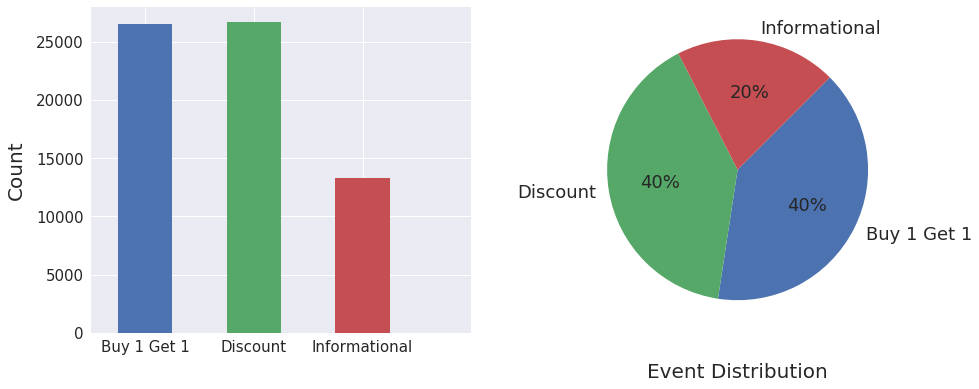

In [283]:
offer_types_dist = full_df[full_df['offer_received']==1][['bogo','discount','informational']].sum()

# Plotting
plt.figure(figsize = [15,6])

# Bar chart
plt.subplot(1,2,1)
offer_types_dist.plot(kind='bar',color=base_color)
plt.xticks([0,1,2,3],['Buy 1 Get 1','Discount','Informational'],rotation = 0,fontsize=15);
plt.ylabel('Count',fontsize=20,labelpad=10,rotation = 90)
plt.yticks(fontsize=15);


# Pie chart
plt.subplot(1,2,2)
offer_types_dist.plot(kind='pie',startangle = 45,counterclock=False,autopct='%1.0f%%',\
                labels=['Buy 1 Get 1','Discount','Informational'],\
                textprops={'fontsize': 18})
plt.ylabel('')
plt.xlabel('Event Distribution',fontsize=20,labelpad=30);

To explore the features relating to completed offers, we will need to find the offers that are successfully completed.
**Successfully completed offers** are offers where users received an offer, viewed it, and then completed the offer during the offer period.

In [284]:
def filter_dataset(df,column,val):
    """ 
    Filter dataset based on a column specified value.
  
    Parameters: 
    pd (pandas dataframe): original dataframe 
    column (string): the name of column where filtering is needed
    val (int or string): the required value of pd[column]
    
    Returns: 
    df_filtered (pandas dataframe): filtered dataframe after column condition is applied 
  
    """
    df_filtered = df[df[column] == val]
    return df_filtered

In [285]:
offer_received = filter_dataset(full_df,'offer_received',1)
offer_viewed = filter_dataset(full_df,'offer_viewed',1)
offer_viewed = offer_viewed[['user_id','offer_id','time']]
offer_completed = filter_dataset(full_df,'offer_completed',1)
offer_completed = offer_completed[['user_id','offer_id','time']] 

In [286]:
# merge completed and viewd dataframes
completed_df = pd.merge(offer_completed,offer_viewed, on=['offer_id','user_id'],\
                     suffixes=('_completed','_viewed'))

In [287]:
# merge them with received dataframe
offer_received.rename(columns = {"time": "time_received"},inplace=True)
completed_df = pd.merge(completed_df,offer_received, on=['offer_id','user_id'])

/home/shahed/.local/lib/python3.6/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Now we need to filter data such that the timing are consistent.

In [288]:
#add time_expire column to represent when an offer will expire
completed_df['time_expired'] = completed_df.apply(lambda e: e.duration * 24 + e.time_received, axis=1)

Now we have a dataset that includes all offers that were recieved, viewed, and completed. We need to do a final check to see that **the user viewed the offer after it was received and completed it before the offer expires**.

In [289]:
completed_df = completed_df[(completed_df['time_received'] <= completed_df['time_viewed'])&\
                     (completed_df['time_completed'] <= completed_df['time_expired']) & (completed_df['time_viewed'] <= completed_df['time_completed']) ]

In [290]:
completed_df['offer_completed'] = 1
completed_df['offer_viewed'] = 1

In [291]:
#remove any duplicates in the dataset
completed_df = completed_df.drop_duplicates(subset=['offer_id','user_id','time_completed'])
completed_df = completed_df.drop_duplicates(subset=['offer_id','user_id','time_viewed'])
completed_df = completed_df.drop_duplicates(subset=['offer_id','user_id','time_received'])

In [292]:
completed_df.head()

,user_id,offer_id,time_completed,time_viewed,time_received,offer_completed,offer_received,offer_viewed,transaction,amount,...,informational,email,mobile,social,web,gender,age,became_member_on,income,time_expired
0,7997,7.0,132,6,0,1,1,1,0,0.0,...,0.0,1.0,1.0,0.0,1.0,F,75,2017-05-09,100000.0,168.0
1,7997,8.0,510,408,408,1,1,1,0,0.0,...,0.0,1.0,1.0,1.0,0.0,F,75,2017-05-09,100000.0,576.0
3,15044,7.0,522,420,408,1,1,1,0,0.0,...,0.0,1.0,1.0,0.0,1.0,M,68,2018-04-26,70000.0,576.0
4,15044,10.0,522,522,504,1,1,1,0,0.0,...,0.0,1.0,1.0,1.0,1.0,M,68,2018-04-26,70000.0,744.0
5,3729,9.0,60,0,0,1,1,1,0,0.0,...,0.0,1.0,1.0,1.0,1.0,M,65,2018-02-09,53000.0,120.0


In [293]:
completed_df.shape

(22192, 27)

### Q4. Which offer type had the highest completion rate?

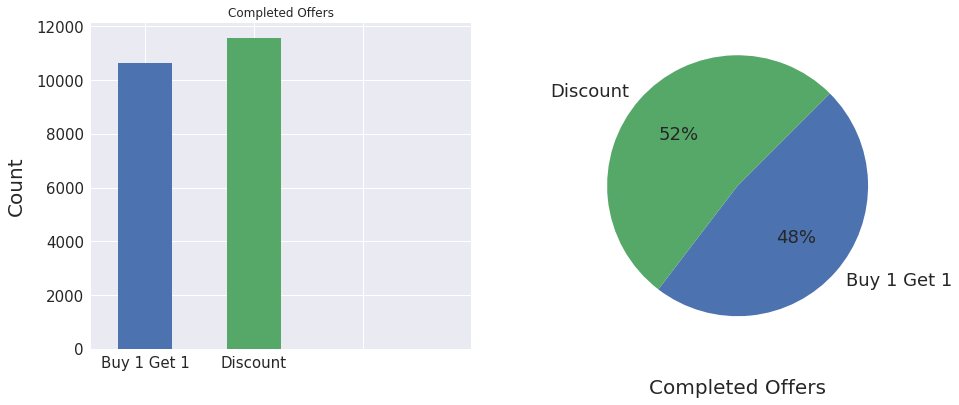

In [294]:
offer_types_dist = completed_df[['bogo','discount']].sum()

# Plotting
plt.figure(figsize = [15,6])

# Bar chart
plt.subplot(1,2,1)
offer_types_dist.plot(kind='bar',color=base_color)
plt.xticks([0,1,2,3],['Buy 1 Get 1','Discount'],rotation = 0,fontsize=15);
plt.title('Completed Offers')
plt.ylabel('Count',fontsize=20,labelpad=10,rotation = 90)
plt.yticks(fontsize=15);

# Pie chart
plt.subplot(1,2,2)
offer_types_dist.plot(kind='pie',startangle = 45,counterclock=False,autopct='%1.0f%%',\
                labels=['Buy 1 Get 1','Discount'],\
                textprops={'fontsize': 18})
plt.ylabel('')
plt.xlabel('Completed Offers',fontsize=20,labelpad=30);



Although the total number of discount and BOGO offers sent are equal, it seems that discount offers are more likely to get completed. This is mostly due to the fact that you don't need to spend a certain amount to get a discount offer, in contrast to BOGO where you are required to meet a certain amount of spending.

### Q4. What is the relation between user demographics (age, gender) and offer completion?

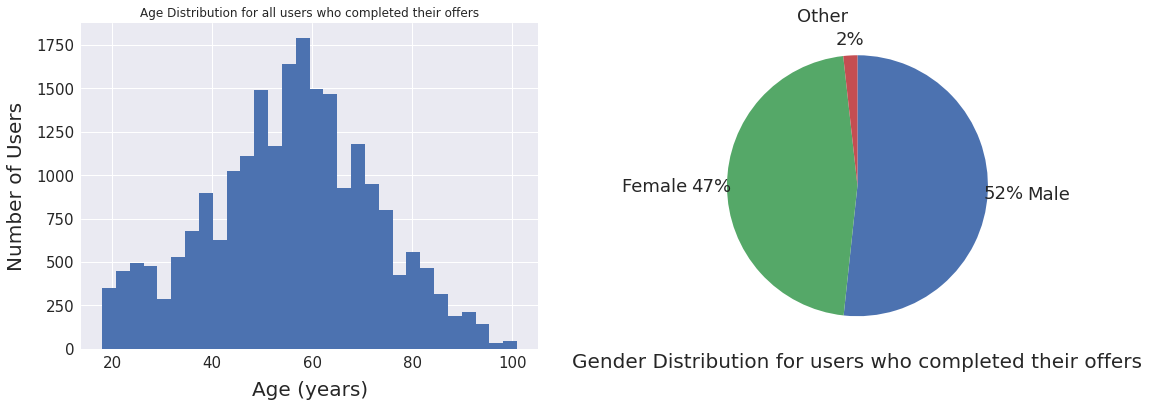

In [295]:
#age histogram
age_dist = completed_df['age']
plt.figure(figsize = [18,6])
plt.subplot(1,2,1)
plt.hist(age_dist, bins = 30);
plt.title('Age Distribution for all users who completed their offers')
plt.xlabel('Age (years)',fontsize=20,labelpad=10)
plt.ylabel('Number of Users',fontsize=20,labelpad=10);
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);


plt.subplot(1,2,2)
gend_dist = completed_df['gender'].value_counts()
gend_dist.plot(kind='pie',startangle = 90,counterclock=False,autopct='%1.0f%%',\
               labels=['Male','Female','Other'],\
               textprops={'fontsize': 18},pctdistance=1.12,labeldistance=1.3)
plt.ylabel('')
plt.xlabel('Gender Distribution for users who completed their offers',fontsize=20);

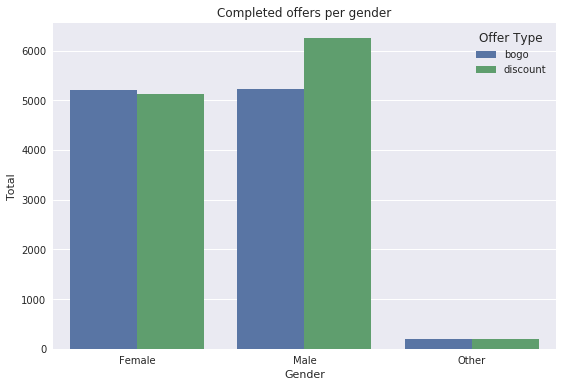

In [296]:
plt.figure(figsize = [9,6])
g = sns.countplot(x="gender", hue="offer_type", data=completed_df)
plt.title('Completed offers per gender')
plt.ylabel('Total')
plt.xlabel('Gender')
xlabels = ['Female', 'Male','Other']
g.set_xticklabels(xlabels)
plt.legend(title='Offer Type')
plt.show();

We see males complete more discount offers, whereas females complete bogo offers more.

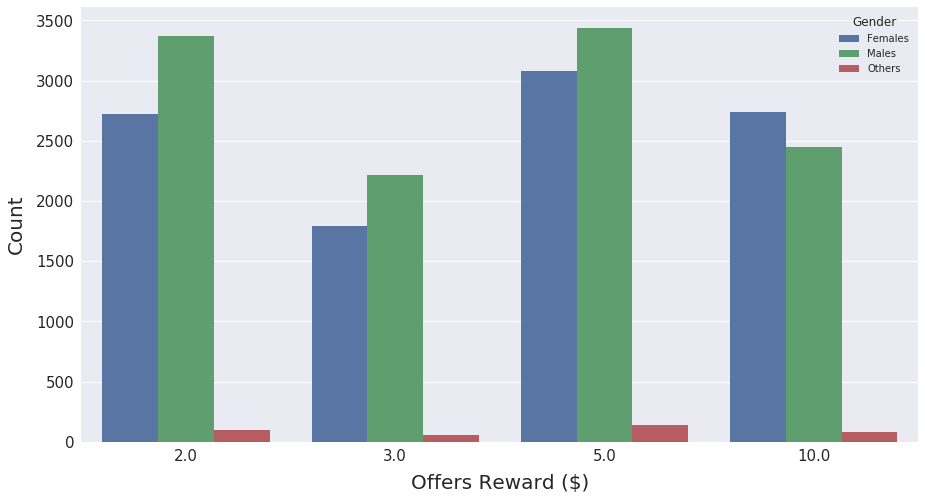

In [297]:
plt.figure(figsize = [15,8])
sns.countplot(x='offer_reward',hue='gender',data = completed_df)
plt.legend(title='Gender', loc='upper right', labels=['Females', 'Males','Others']);
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);

plt.xlabel('Offers Reward ($)',fontsize=20,labelpad=10);
plt.ylabel('Count',fontsize=20,labelpad=10);

It looks like females are more attracted towards the $10 offer rewards than males. 

### Q5. What is average amount of spending by age?

Text(0, 0.5, 'Amount ($)')

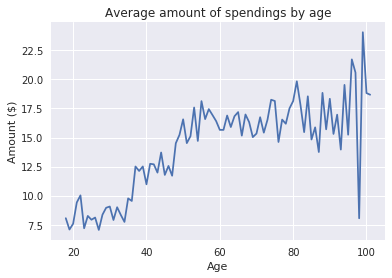

In [298]:
transactions = full_df[full_df['transaction'] == 1]
spending_avg = transactions.groupby('age').mean()
plt.plot(spending_avg.index,spending_avg['amount'])
plt.title('Average amount of spendings by age')
plt.xlabel('Age')
plt.ylabel('Amount ($)')

# Data Modelling

Now that we have analyzed the dataset, we will proceed by creating a model that would predict whether a user will respond to an offer or not.
There are 4 scenarios that can happen:
1. A user will view and complete the offer.
2. A user will just view the offer.
3. A user will not view the offer, but will complete it anyway (without prior knowledge of the offer existence)
4. A user will not view the offer and will not complete it.

Since starbucks are targetting users that will view the offer and complete it afterwards, our prediction would be a binary value as such:
1: User will view and complete the offer
0: Otherwise


In order to proceed with the prediction, we will need to create a new dataframe that will include the targeted features and the prediction column. 
The features that will be analyzed are: 
* Age
* Income
* Gender
* Offer_type
* Reward
* Duration
* Difficulty
* Channels




A new column will be created "offer_success" to show wehther a user will successfully view and complete the offer.

From the datasets, Offer types BOGO and discount have a clear criteria for completion and can be founded by looking at the event column with value "completed offer" and then double check that the timing of completion and viewing and offer expiration are consistent.

However, dealing with informational offers is different. Since informational offers are advertisement offers that don't have a completion criteria, we will need to define how to consider them successful.

One way would be to look at all transactions and check if a transaction has occurred during an informational offer period. These transactions are considered to be influenced by the offer and thus the informational offer was successful. This is, of course, under the condition that a user has received and viewed the informational offer, THEN proceed to make a transaction.

In order to do that, i will create one dataset that includes all pairs (user_id and offer_id) of completed offers for Bogo and discount. I will also create another dataset that includes all pairs (user_id and offer_id) of completed offers for type informational.

Next, I will merge them together into a bigger dataset including all successfully completed offers.

In [299]:
#Create completed offer dataset for bogo and discount offers.
offer_received_df = transcript[transcript['offer_received'] == 1][['offer_id','user_id','time']]\
.rename(columns={"time":"time_received"})

offer_viewed_df = transcript[transcript['offer_viewed'] == 1][['offer_id','user_id','time']]

offer_completed_df = transcript[transcript['offer_completed'] == 1][['offer_id','user_id','time']]

complete_bogo_discount_df = pd.merge(offer_completed_df,offer_viewed_df, on=['offer_id','user_id'],\
                     suffixes=('_completed','_viewed'))

# merge them with received dataframe
complete_bogo_discount_df = pd.merge(complete_bogo_discount_df,offer_received_df, on=['offer_id','user_id'])

In [300]:
#merge with portfolio to find time_expired column
complete_bogo_discount_df = pd.merge(complete_bogo_discount_df, portfolio, on='offer_id')

In [301]:
complete_bogo_discount_df['time_expire'] = complete_bogo_discount_df.apply(lambda x: x['time_received']+ x['duration']*24,axis =1)

complete_bogo_discount_df = complete_bogo_discount_df[(complete_bogo_discount_df['time_received'] <= complete_bogo_discount_df['time_viewed']) \
                               & (complete_bogo_discount_df['time_viewed'] <= complete_bogo_discount_df['time_completed'])\
                               & (complete_bogo_discount_df['time_completed'] <= complete_bogo_discount_df['time_expire']) ]


We have created the first dataset, we will repeat similar logic to create second dataset.

In [302]:
#Create completed offer dataset for inforamtional offer based on transaction.

# Dataframe holding the events where a transaction took place
transaction_df = transcript[(transcript['transaction'] == 1)][['user_id','time','amount']]

# merge transaction and adv_viewd dataframes
complete_info_df = pd.merge(transaction_df,offer_viewed_df, on=['user_id'],suffixes=('_transaction','_viewed'))

# merge them with received dataframe
complete_info_df = pd.merge(complete_info_df,offer_received_df, on=['offer_id','user_id'])


complete_info_df = pd.merge(complete_info_df, portfolio, on='offer_id')
# Calculate offer expiration
complete_info_df['time_expire'] = complete_info_df.apply(lambda x: x['time_received']+ x['duration']*24,axis =1)

#Choose only informational offer
complete_info_df = complete_info_df[complete_info_df['informational'] == 1]

In [303]:
#filter based on the mentioned criteria
complete_info_df = complete_info_df[(complete_info_df['time_viewed'] >= complete_info_df['time_received']) &\
                 (complete_info_df['time_transaction'] <= complete_info_df['time_expire']) & \
                (complete_info_df['time_viewed'] <= complete_info_df['time_transaction'])]


In [304]:
complete_bogo_discount_df['offer_success'] = 1
complete_info_df['offer_success'] = 1

In [305]:
complete_bogo_discount_df=complete_bogo_discount_df[['user_id','offer_id','offer_success']]
complete_info_df=complete_info_df[['user_id','offer_id','offer_success']]

In [306]:
concat_pd = complete_bogo_discount_df.append(complete_info_df)

In [307]:
#merge the concat_pd with all pairs of user_id and offer_id received, then fill the remaining as unsuccessful offers
df1 = offer_received_df.set_index(['offer_id','user_id'])
df2 = concat_pd.set_index(['offer_id','user_id'])
all_clean_df = pd.merge(df1,df2,left_index=True,right_index=True,how="left")

#Consider the other offers as unsuccessful
all_clean_df ['offer_success'] = all_clean_df ['offer_success'].fillna(0)

In [308]:
all_clean_df = all_clean_df.reset_index()

In [309]:
model_df = all_clean_df[['user_id','offer_id','offer_success']]

model_df = pd.merge(model_df, portfolio, on='offer_id')
model_df = pd.merge(model_df, profile, on='user_id')

model_df  = model_df .drop(['became_member_on','offer_type'],axis =1)

In [310]:
def normalize_data(df,column):
    """
    normalizes column using min-max normalization:
    
    Input:
    df (pandas Dataframe): input dataframe
    column (string): name of column that needs to be normalized
    
    Return
    normal_df (pandas Dataframe): dataframe after normalization

    """
    df[column] = (df[column]-df[column].min())/(df[column].max()-df[column].min())
    
    return df
    

In [311]:
#create integer mapping for gender column
gender_map = create_mapping_dict(model_df,'gender')
model_df = map_string_to_int(model_df,'gender',gender_map)

#normalize income and age
model_df = normalize_data(model_df,'age')
model_df = normalize_data(model_df,'income')

Three classifier algorithms will be used
1. LinearSVC
2. Decision Tree Classifier
3. k-nearest neighbors

To evaluate a model, we will look into **f1-score**. The F1 score can be interpreted as a weighted average of the precision and recall which conveys the balance between them.

Looking at Precision value alone would ignore the False Negatives and would make us miss valuable customers that can potentially complete an offer.

Similarity, looking at Recall value alone would ignore False Positives which can make us send offers to everyone and flood users with offers they are not interested in.

For that, F1 score is the best choice in this case as it provides the balance between them.

In [312]:
X = model_df.drop(['offer_success','offer_id','user_id'],axis=1)
y = model_df['offer_success']

# Split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2,random_state = 42)


In [313]:
def train_model(clf, parameters, X_train,Y_train):
    """
    fits model to dataset. Uses gridsearch to tune parameters of classification model
    
    Input:
    clf: classificatio model
    parameters (dictionary): gridsearch parameters
    X_train (dataframe): training dataframe
    Y_train: output for training dataset
    
    Return:
    cv: model after fitting to dataset
    """
    cv = GridSearchCV(clf, param_grid=parameters,cv =2)
    cv.fit(X_train, Y_train)
    return cv

In [314]:
def predict_model(cv,X_test,Y_test):
    """
    predict test data and prints classification report.
    
    Input:
    cv: trained model
    X_test (dataframe): test dataframe
    Y_train: correct output for test data
    
    """
    y_pred = cv.predict(X_test)
    print(classification_report(Y_test, y_pred, target_names=['User will not complete','User will complete']))
    

In [315]:
print("***LinearSVC***")
parameters = {"C": [1, 100]}
print('hyperparameters: \n')
print(parameters)
print("\n***************")
svc_cv = train_model(LinearSVC(dual=False),parameters,X_train,Y_train)
print(f'Best parameters: {svc_cv.best_params_}')
predict_model(svc_cv,X_test,Y_test)

***LinearSVC***
hyperparameters: 

{'C': [1, 100]}

***************
Best parameters: {'C': 100}
                        precision    recall  f1-score   support

User will not complete       0.63      0.51      0.56      6928
    User will complete       0.69      0.78      0.73      9575

              accuracy                           0.67     16503
             macro avg       0.66      0.64      0.65     16503
          weighted avg       0.66      0.67      0.66     16503



In [316]:
print('***DecisionTreeClassifier***')
parameters = {'max_features': [0.25, 0.5, 0.75, None],
             'max_depth': [8, 10, 12, None],
             'min_samples_split': [100, 60, 20],
             'min_samples_leaf': [100,50, 30, 10]}
print('hyperparameters: \n')
print(parameters)
print("\n***************")
dt_cv = train_model(DecisionTreeClassifier(random_state=0),parameters,X_train,Y_train)
print(f'Best parameters: {dt_cv.best_params_}')
predict_model(dt_cv,X_test,Y_test)

***DecisionTreeClassifier***
hyperparameters: 

{'max_features': [0.25, 0.5, 0.75, None], 'max_depth': [8, 10, 12, None], 'min_samples_split': [100, 60, 20], 'min_samples_leaf': [100, 50, 30, 10]}

***************
Best parameters: {'max_depth': None, 'max_features': 0.75, 'min_samples_leaf': 50, 'min_samples_split': 100}
                        precision    recall  f1-score   support

User will not complete       0.65      0.54      0.59      6928
    User will complete       0.70      0.79      0.74      9575

              accuracy                           0.69     16503
             macro avg       0.68      0.67      0.67     16503
          weighted avg       0.68      0.69      0.68     16503



In [317]:
print('***KNeighborsClassifier***')
knn = KNeighborsClassifier()
parameters = {'n_neighbors': [5, 10, 30],
              'p': [1, 2, 3]}
print('hyperparameters: \n')
print(parameters)
print("\n***************")
knn_cv = train_model(KNeighborsClassifier(),parameters,X_train,Y_train)
print(f'Best parameters: {knn_cv.best_params_}')
predict_model(knn_cv,X_test,Y_test)

***KNeighborsClassifier***
hyperparameters: 

{'n_neighbors': [5, 10, 30], 'p': [1, 2, 3]}

***************
Best parameters: {'n_neighbors': 5, 'p': 2}
                        precision    recall  f1-score   support

User will not complete       0.69      0.59      0.64      6928
    User will complete       0.73      0.80      0.77      9575

              accuracy                           0.72     16503
             macro avg       0.71      0.70      0.70     16503
          weighted avg       0.71      0.72      0.71     16503



Looking at the results above, KNeighborsClassifier performed the best with an f1-score of 0.64 for users who will not complete offer and 0.77 for users who complete an offer. The average accuracy is 0.71.

In [318]:
arrays = [np.array(['precision', 'precision', 'recall', 'recall', 'f1-score', 'f1-score']),
          np.array(['User will not complete', 'User will complete', 'User will not complete', 'User will complete', 'User will not complete', 'User will complete'])]

In [319]:
df = pd.DataFrame([[0.63,0.65,0.69],[0.69,0.70,0.73],[0.51,0.54,0.59],[0.78,0.79,0.80],[0.56,0.59,0.64],[0.73,0.74,0.77]], index=arrays,columns =['LinearSVC','DecisionTreeClassifier','KNeighborsClassifier'] )

In [320]:
df

LinearSVC  DecisionTreeClassifier  \
precision User will not complete       0.63                    0.65   
          User will complete           0.69                    0.70   
recall    User will not complete       0.51                    0.54   
          User will complete           0.78                    0.79   
f1-score  User will not complete       0.56                    0.59   
          User will complete           0.73                    0.74   

                                  KNeighborsClassifier  
precision User will not complete                  0.69  
          User will complete                      0.73  
recall    User will not complete                  0.59  
          User will complete                      0.80  
f1-score  User will not complete                  0.64  
          User will complete                      0.77

## Conclusion
In the above analysis, we looked at Starbucks data and saw how offer features and user demographics affect how a user would respond to a an offer.  

After doing dome deeper analysis and visualization we saw that some features such as gender affected a user response to an offer. Males were more likely to complete an offer and especially discount offers whereas women preferred high reward offers ($10).On the other hand, we saw that the age of the user has no effect in that matter.
We discovered some trends on user spending and we saw that users who are older (in their 50’s or 60’s) are more likely to spend more.

we also looked at how the data is spread and we saw that only 11% of the offers sent were actually completed and 19% was viewed. The remaining offers were not touched.

To wrap things up, we built a classification model to predict whether a user would complete an offer or not. We saw that KNeighborsClassifier had the best results. The model was able to classify completed offers better and it had an average accuracy of 71% which is good given the limited dataset and the small number of effective features. [5,10,30] neighbors were tested with gridsearch to give the above result.


We had missing information for so many users in the dataset and therefore their data was dismissed. The experiment was also run for a short period of time, which doesn’t give enough input into how users react to the offers.


One improvement for the model was made after normalizing the income feature as it had very large values compared to the rest of the data.

## Reflection
In conclusion, we went through several steps with the analysis to answer our problem statement.
The steps can be summarized as follows:

1. Understand the dataset and all its features.
2. Clean and modify the data to prepare it for visualization and modelling.
    - Null and duplicate values were removed
    -  For categorical values such as offer_type and event, separate columns were generated to replace them.
    - Invalid data such as missing user information was handled.
3. Visualize and explore data.
    - Data distribution of age, gender, event, and offer types were looked at.
    - Relation between user demographics and response to offers.
4. Identify successfully completed offers from unsuccessful offers and represent them properly.
5. Predict user response to offers using ML classification models.
6. Evaluate results and choose the most appropriate model.

In this project, I learned so many things and explored different areas of data science.
My favorite step was step 3 of visualizing data. My most challenging step was step 4 as it was difficult dealing with the fact that users can complete an offer without viewing it or that an offer can be sent to user multiple times.



## Improvement
One thing that can be done is to increase the duration of the experiment. A period of one month is short and would not be sufficient to describe user behavior as users spending can be different every month. A period of 3 or 6 months is more suitable.

We can also create an A/B experiment to split users and check how well our prediction model work.